In [21]:
import math
import glob
import numpy as np
from PIL import Image


# parameters

datadir = './data'
resultdir='./results'

# you can calibrate these parameters
sigma=2
Gaussian_size= (3,3)
highThreshold=0.1 #max에서 몇퍼센트
lowThreshold=0.5 #highThreshold에서 몇퍼센트

rhoRes=2
thetaRes=math.pi/180
nLines=20


def replic_pad(Igs,size):
    H,W = Igs.shape
    h,w = size 
    h2,w2 = h//2, w//2
    padded = np.zeros((H+2*h2,W+2*w2))
    padded[h2:H+h2,w2:W+w2] = Igs[:,:].copy()
    
    for i in range(0,h2):
        padded[i,:] = padded[h2,:]
        padded[H+2*h2-1-i,:] = padded[H+h2-1,:]

    for j in range(0,w2):
        padded[:,j] = padded[:,w2].copy()
        padded[:,W+2*w2-1-j] = padded[:,W+w2-1]

        
    return padded  
    

def ConvFilter(Igs, G):
    for s in G.shape:
        if s % 2 == 0:
            raise Exception("Kernel size must be odd")
    
    h, w = G.shape 
    h2, w2 = h//2, w//2
    padded = replic_pad(Igs.copy(), G.shape)
    H, W = padded.shape 
        
    #flip kernel
    for i in range(h2):
        G[i,:], G[2*h2-i,:] = G[2*h2-i,:].copy(), G[i,:].copy()
    for j in range(w2):
        G[:,j], G[:,2*w2-j] = G[:,2*w2-j].copy(), G[:,j].copy()
       
    #convolve
    Iconv = np.zeros(Igs.shape)   
    for i in range(h2,H-h2):
        for j in range(w2,W-w2):
            sum = 0
            for k in range(h):
                for l in range(w):
                    sum += padded[i-h2+k,j-w2+l]*G[k,l]
            Iconv[i-h2,j-w2] = sum
    
    return Iconv

def GaussianFilter(Igs,sigma,size):
    
    h,w = size
    h2,w2 = h//2, w//2
    
    col = np.zeros((h,1))
    row = np.zeros((1,w))
    colsum, rowsum = 0, 0
    col1 = math.exp(-math.pow(-h2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
    row1 = math.exp(-math.pow(-w2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
   
    for i in range(h):
        col[i,:] = math.exp(-math.pow(i-h2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
        col[i,:] = np.round(col[i,:]/col1)
        colsum += col[i,:]       
    for j in range(w):
        row[:,j] = math.exp(-math.pow(j-w2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
        row[:,j] = np.round(row[:,j]/row1) 
        rowsum += row[:,j]

    gaussian = np.zeros(Igs.shape)
    gaussian = ConvFilter(ConvFilter(Igs.copy(),col),row)

    return gaussian/(rowsum*colsum)

def NMS(Im,Io):
    
    H,W = Im.shape
    nms = Im.copy()
       
    for i in range(0,H):
        for j in range(0,W):
            if (i !=0 and j !=0 and i != H-1 and j != W-1):
                if (Io[i,j] < 0 ):
                    Io[i,j] += 180
                if (0 <= Io[i,j] < 22.5 or 157.5 <= Io[i,j] <= 180):
                    if(Io[i,j] < Io[i,j-1] or Io[i,j] < Io[i,j+1]):
                        nms[i,j] = 0
                elif (22.5 <= Io[i,j] < 67.5):
                    if(Io[i,j] < Io[i-1,j-1] or Io[i,j] < Io[i+1,j+1]):
                        nms[i,j] = 0
                elif (67.5 <= Io[i,j] < 112.5):
                    if(Io[i,j] < Io[i-1,j] or Io[i,j] < Io[i+1,j]):
                        nms[i,j] = 0
                elif (112.5 <= Io[i,j] < 157.5):
                    if(Io[i,j] < Io[i+1,j-1] or Io[i,j] < Io[i-1,j+1]):
                        nms[i,j] = 0
            else:
                nms[i,j] = 0
    
    return nms

            
def doubleTH(Im, highThreshold, lowThreshold):
    
    H,W = Im.shape
    highTH = Im.max()*highThreshold
    lowTH = highTH*lowThreshold
    TH = np.zeros(Im.shape)
    strong_edge = 255
    weak_edge = 50
    str_num = 0
    weak_num = 0
    
    #double Threshold
    for i in range(H):
        for j in range(W):
            if (Im[i,j] >= highTH):
                TH[i,j] = strong_edge
                str_num += 1 
            elif (Im[i,j] < highTH and Im[i,j] >= lowTH):
                TH[i,j] = weak_edge
                weak_num += 1 
    print("총", H*W,"strong",str_num,"weak",weak_num)
    
    str_num2 = 0
    #Hysteresis based
    hys = TH.copy()           
    for i in range(0,H):
        for j in range(0,W):
            if (i!=0 and i!=H-1 and j!=0 and j!=W-1):
                if (TH[i,j] == weak_edge):
                    if ((TH[i,j-1] == strong_edge) or
                        (TH[i-1,j-1] == strong_edge) or
                        (TH[i-1,j] == strong_edge) or
                        (TH[i-1,j+1] == strong_edge) or
                        (TH[i,j+1] == strong_edge) or
                        (TH[i+1,j+1] == strong_edge) or
                        (TH[i+1,j] == strong_edge) or
                        (TH[i+1,j-1] == strong_edge)):
                        hys[i,j] = strong_edge
                        str_num2 += 1
                    else:
                        hys[i,j] = 0
            else:
                hys[i,j] = 0
    print(weak_num."중",str_num2,"개 strong에 추가")
                    
    return hys
                
    
    
def EdgeDetection(Igs, sigma, highThreshold, lowThreshold):
    
    sblx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]],np.float32)
    sbly = np.array([[-1,-2,-1],[0,0,0],[1,2,1]],np.float32)
    
    smoothed = GaussianFilter(Igs.copy(),sigma,Gaussian_size)

    Ix = ConvFilter(smoothed,sblx)
    Iy = ConvFilter(smoothed,sbly)
    
    Io = np.zeros(smoothed.shape)
    Io = np.arctan2(Iy,Ix)*180/math.pi
    
    Im = np.zeros(smoothed.shape)
    for i in range(smoothed.shape[0]):
        for j in range(smoothed.shape[1]):
            Im[i,j] = math.sqrt(math.pow(Ix[i,j],2)+math.pow(Iy[i,j],2))
    Im = Im/Im.max()
    
    Im = NMS(Im,Io)
    Im = doubleTH(Im,highThreshold,lowThreshold)
    
    return Im, Io, Ix, Iy

def HoughTransform(Im, rhoRes, thetaRes):
    
    H,W = Im.shape    
    rho_max = math.ceil(math.sqrt(H*H + W*W))
    theta_max = 2*math.pi                        
    rho = np.arange(0,rho_max + rhoRes,rhoRes)
    theta = np.arange(0,theta_max + thetaRes,thetaRes)
    
    cos_ = np.cos(theta)
    sin_ = np.sin(theta)
    rho_index = len(rho)
    theta_index = len(theta)

    acc = np.zeros((rho_index,theta_index))
    for i in range(H):
        for j in range(W):
            if (Im[i,j] != 0):
                for theta_ in range(theta_index):
                    rho_ = round(i*cos_[theta_]+j*sin_[theta_])
                    if (0<=rho_<=rho_max):
                        acc[rho_//rhoRes,theta_] += 1

    return acc

def HoughLines(H,rhoRes,thetaRes,nLines):

    h,w = H.shape    
    
    for i in range(0,h):
        for j in range(0,w):
            if (i!=0 and j!=0 and i!=h-1 and j!=w-1):
                if ((H[i,j-1] >= H[i,j]) or
                        (H[i-1,j-1] >= H[i,j]) or
                        (H[i-1,j] >= H[i,j]) or
                        (H[i-1,j+1] >= H[i,j]) or
                        (H[i,j+1] >= H[i,j]) or
                        (H[i+1,j+1] >= H[i,j]) or
                        (H[i+1,j] >= H[i,j]) or
                        (H[i+1,j-1] >= H[i,j])):
                    H[i,j] == 0
            else:
                H[i,j] == 0                        
    lRho, lTheta = np.unravel_index(np.argsort(-1*H,axis=None)[:nLines],H.shape)
    for i in range(len(lRho)):
        print(i+1,"번째로 큰 vote 수:", H[lRho[i],ITheta[i]])
      
    return lRho,lTheta

def HoughLineSegments(IRho: list, ITheta: list, Im):
    l = []#empty list --> [{'start': [x_s,y_s], 'end': [x_e,y_e]}, {}, ...]
    nonzero = np.transpose(np.nonzero(Im))
    
    interval = 10                       
    rho = np.arange(0,rho_max + rhoRes,rhoRes)
    theta = np.arange(0,theta_max + thetaRes,thetaRes)
    
    cos_ = np.cos(theta)
    sin_ = np.sin(theta)
    rho_index = len(rho)
    theta_index = len(theta)
    

   
    for line_num in range(len(IRho)):
        theta_ = ITheta[line_num] 
        rho_ = IRho[line_num] 
        point_list = [] #일단 edge 위의 모든 점을 point_list에 저장
        segment = []
        temp = []
        for point in nonzero:
                    if(rho_ == round(round(point[0]*cos_[theta_]+point[1]*sin_[theta_])//rhoRes)):
                        point_list.append(point)
        for i in range(len(point_list)):
            if (i>0):
                if(abs(point_list[i][1] - point_list[i-1][1]) > interval or abs(point_list[i][0]-point_list[i-1][0]) > interval):
                    segment.append(temp)
                    print(line_num,': segment',i,temp)
                    temp = []
            temp.append(point_list[i])
        segment.append(temp)
        print("segment 개수", len(segment))
               
        maxlist = max(segment,key=len)
        if(len(maxlist)!=0):
            d = {'start':maxlist[0],'end':maxlist[-1]}
            l.append(d)
    print("직선",line_num,":",maxlist[0],maxlist[-1])
      
    return l



SyntaxError: invalid syntax (Temp/ipykernel_10624/525385453.py, line 166)

In [12]:
from matplotlib import pyplot as plt
from scipy import ndimage
datadir = './data'

for img_path in glob.glob(datadir+'/*.jpg'):
        # load grayscale image
    img = Image.open(img_path).convert("L")
    Igs = np.array(img.copy())        
        
    Im, Io, Ix, Iy = EdgeDetection(Igs, sigma, highThreshold, lowThreshold)
    H = HoughTransform(Im, rhoRes, thetaRes)
    lRho,lTheta =HoughLines(H,rhoRes,thetaRes,nLines)
#         l = HoughLineSegments(lRho, lTheta, Im)
        

#     plt.figure()
#     plt.imshow(Im.astype(np.uint8),cmap='gray')
#     plt.axis('on')
#     plt.show()
        
#     plt.figure()
#     plt.imshow(H,cmap='gray')
#     plt.axis('on')
#     plt.show()
        
#         plt.figure()
#         plt.imshow(H,cmap='gray')
#         plt.axis('on')
#         plt.show()


NameError: name 'acc' is not defined

In [233]:
def main():

    # read images
    for img_path in glob.glob(datadir+'/*.jpg'):
        # load grayscale image
        img = Image.open(img_path).convert("L")

        Igs = np.array(img)
        Igs = Igs / 255.

        # Hough function
        Im, Io, Ix, Iy = EdgeDetection(Igs, sigma, highThreshold, lowThreshold)
        H= HoughTransform(Im, rhoRes, thetaRes)
        lRho,lTheta =HoughLines(H,rhoRes,thetaRes,nLines)
        l = HoughLineSegments(lRho, lTheta, Im)

        # saves the outputs to files
        # Im, H, Im + hough line , Im + hough line segments


if __name__ == '__main__':
    main()

IndexError: list index out of range

In [99]:
h,w = (5,5)
h2,w2 = h//2, w//2
sigma = 1
col = np.zeros((h,1))
row = np.zeros((1,w))
col1 = math.exp(-math.pow(-h2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
row1 = math.exp(-math.pow(-w2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
colsum, rowsum = 0, 0
for i in range(h):
    col[i,:] = math.exp(-math.pow(i-h2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
    col[i,:] = np.round(col[i,:]/col1)
    colsum += col[i,:]       
for j in range(w):
    row[:,j] = math.exp(-math.pow(j-w2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
    row[:,j] /= row1
    rowsum += row[:,j]
    
col

array([[1.],
       [4.],
       [7.],
       [4.],
       [1.]])

In [58]:
import math
import glob
import numpy as np
from PIL import Image

def replic_pad(input_image,size):
    H,W = input_image.shape
    h,w = size.shape
    h2,w2 = h//2, w//2
    
    padded = np.full((H+2*h2,W+2*w2),-1)
    padded[h2:H+h2,w2:W+w2] = input_image[:,:].copy()
    
    for i in range(0,h2):
        padded[i,:] = padded[h2,:]
        padded[H+2*h2-1-i,:] = padded[H+h2-1,:]

    for j in range(0,w2):
        padded[:,j] = padded[:,w2].copy()
        padded[:,W+2*w2-1-j] = padded[:,W+w2-1]
        
        
    for i in range(padded.shape[0]):
        for j in range(padded.shape[1]):
            if (padded[i,j] == -1):
                print("padding error",i,j)
        
    return padded  
    
def ConvFilter(Igs, G):
    for s in G.shape:
        if s % 2 == 0:
            raise Exception("Kernel size must be odd")
    
    h, w = G.shape 
    h2, w2 = h//2, w//2
    padded = replic_pad(Igs.copy(), G)
    H, W = padded.shape 
        
    #flip kernel
    for i in range(h2):
        G[i,:], G[2*h2-i,:] = G[2*h2-i,:].copy(), G[i,:].copy()
    for j in range(w2):
        G[:,j], G[:,2*w2-j] = G[:,2*w2-j].copy(), G[:,j].copy()
       
    #convolve
    Iconv = np.zeros(Igs.shape)   
    for i in range(h2,H-h2):
        for j in range(w2,W-w2):
            sum = 0
            for k in range(h):
                for l in range(w):
                    sum += padded[i-h2+k,j-w2+l]*G[k,l]
            Iconv[i-h2,j-w2] = sum
    
    
    return Iconv

In [181]:
def GaussianFilter(Igs,sigma,size):
    
    h,w = size
    h2,w2 = h//2, w//2
    
    col = np.zeros((h,1))
    row = np.zeros((1,w))
    colsum, rowsum = 0, 0
    col1 = math.exp(-math.pow(-h2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
    row1 = math.exp(-math.pow(-w2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
   
    for i in range(h):
        col[i,:] = math.exp(-math.pow(i-h2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
        col[i,:] = np.round(col[i,:]/col1)
        colsum += col[i,:]       
    for j in range(w):
        row[:,j] = math.exp(-math.pow(j-w2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
        row[:,j] = np.round(row[:,j]/row1) 
        rowsum += row[:,j]

    gaussian = np.zeros(Igs.shape)
    gaussian = ConvFilter(ConvFilter(Igs.copy(),col),row)

    return gaussian/(rowsum*colsum)
def NMS(Im,Io):
    H,W = Im.shape
    nms = Im.copy()
    
    
    for i in range(1,H-1):
        for j in range(1,W-1):
            if (Io[i,j] < 0 ):
                Io[i,j] += 180
            if (0 <= Io[i,j] < 22.5 or 157.5 <= Io[i,j] <= 180):
                if(Io[i,j] < Io[i,j-1] or Io[i,j] < Io[i,j+1]):
                    nms[i,j] = 0
            elif (22.5 <= Io[i,j] < 67.5):
                if(Io[i,j] < Io[i-1,j-1] or Io[i,j] < Io[i+1,j+1]):
                    nms[i,j] = 0
            elif (67.5 <= Io[i,j] < 112.5):
                if(Io[i,j] < Io[i-1,j] or Io[i,j] < Io[i+1,j]):
                    nms[i,j] = 0
            elif (112.5 <= Io[i,j] < 157.5):
                if(Io[i,j] < Io[i+1,j-1] or Io[i,j] < Io[i-1,j+1]):
                    nms[i,j] = 0
    return nms

def doubleTH(Im, highThreshold, lowThreshold, strong_edge, weak_edge):
    
    H,W = Im.shape
    highTH = Im.max()*highThreshold
    lowTH = highTH*lowThreshold
    TH = np.zeros(Im.shape)
    
    #double Threshold
    for i in range(H):
        for j in range(W):
            if (Im[i,j] >= highTH):
                TH[i,j] = strong_edge
            elif (Im[i,j] < highTH and Im[i,j] >= lowTH):
                TH[i,j] = weak_edge
                
    #Hysteresis based
    hys = TH.copy()           
    for i in range(1,H-1):
        for j in range(1,W-1):
            if (TH[i,j] == weak_edge):
                if ((TH[i,j-1] == strong_edge) or
                    (TH[i-1,j-1] == strong_edge) or
                    (TH[i-1,j] == strong_edge) or
                    (TH[i-1,j+1] == strong_edge) or
                    (TH[i,j+1] == strong_edge) or
                    (TH[i+1,j+1] == strong_edge) or
                    (TH[i+1,j] == strong_edge) or
                    (TH[i+1,j-1] == strong_edge)):
                    hys[i,j] = strong_edge
                else:
                    hys[i,j] = 0
    
    return hys

def HoughTransform(Im, rhoRes, thetaRes):
    H,W = Im.shape
    
    rho_max = math.ceil(math.sqrt(H*H + W*W))
    rho = np.arange(0.,rho_max + rhoRes,rhoRes)                  
    theta = np.arange(0.,2*math.pi+thetaRes,thetaRes)
    cos_ = np.cos(theta)
    sin_ = np.sin(theta)

    acc = np.zeros((len(rho),len(theta)))
    for i in range(H):
        for j in range(W):
            if (Im[i,j] != 0):
                for theta_ in range(len(theta)):
                    rho_ = round(i*cos_[theta_]+j*sin_[theta_])
                    if (0<=rho_<=rho_max):
                        acc[rho_//rhoRes,theta_] += 1
    H = acc.copy()

    return H

float64 255.0 29.387543252595155


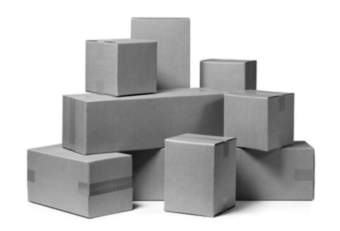

float64 251.46020761245674 0.08996539792387544


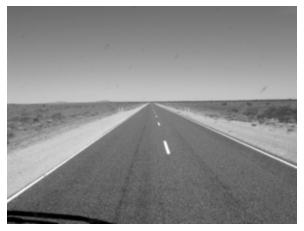

float64 250.4878892733564 15.217993079584774


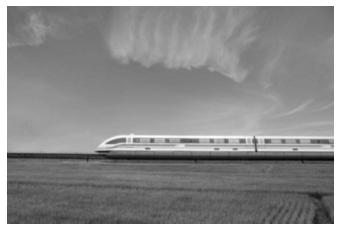

float64 252.5190311418685 32.30795847750865


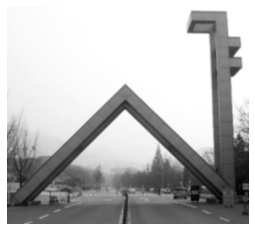

In [155]:
from matplotlib import pyplot as plt
from scipy import ndimage
datadir = './data'

for img_path in glob.glob(datadir+'/*.jpg'):
        # load grayscale image
        img = Image.open(img_path).convert("L")
        Igs = np.array(img.copy())
        
        Igs = GaussianFilter(Igs,1,(5,5))
        print(Igs.dtype,Igs.max(),Igs.min())
        Igs = Igs/255
        plt.figure()
        plt.imshow(Igs,cmap='gray')
        plt.axis('off')
        plt.show()

In [152]:
def HoughLineSegments(IRho: list, ITheta: list, Im):
    l = [] #empty list --> [{'start': [x_s,y_s], 'end': [x_e,y_e]}, {}, ...]
    interval = 1
    print(IRho,ITheta)
    
    for line_num in range(len(IRho)):
        theta_ = ITheta[line_num] #x-axis
        rho_ = IRho[line_num] #y-axis
        print(theta_,rho_)
        point_list = [] #일단 edge 위의 모든 점을 point_list에 저장
        segment = []
        temp = []
        if (math.sin(theta_)!=0):
            print('sin is not 0')
            for x_ in range(Im.shape[1]):
                y_ = round(-math.cos(theta_)/math.sin(theta_)*x_ + rho_/math.sin(theta_))
                if (0 <= y_ < Im.shape[0] and Im[y_,x_] != 0):
                    one_point = [y_, x_]
                    point_list.append(one_point)
            print(point_list)
            for i in range(len(point_list)):
                if(abs(point_list[i][1] - point_list[i-1][1]) > interval and i > 0):
                    segment.append(temp)
                    print(line_num,': segment',i,temp)
                    temp = []
                temp.append(point_list[i])
            segment.append(temp)
        elif (math.cos(theta_)!=0):
            print('sin is 0')
            for y_ in range(Im.shape[0]):
                x_ = round(rho_/math.cos(theta_))
                if (0<=x_<Im.shape[1] and Im[y_,x_]!=0):
                    one_point = [y_,x_]
                    point_list.append(one_point)
            print(point_list)
            for i in range(len(point_list)):
                if(abs(point_list[i][0] - point_list[i-1][0]) > interval and i > 0):
                    segment.append(temp)
                    print(line_num,': segment',i,temp)
                    temp = []
                temp.append(point_list[i])
            segment.append(temp)               
                    
        maxlist = max(segment,key=len)
        print(maxlist)
        d = {'start':maxlist[0],'end':maxlist[-1]}
        l.append(d)
      
    return l
                        
            
                
                
                
        #찾은 edge를 l의 line_num번째 element로 dictionary를 만들어 넣어줌

array([ 1.        ,  0.54030231, -0.41614684, -0.9899925 , -0.65364362,
        0.28366219,  0.96017029,  0.75390225])

In [190]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
np.unravel_index(np.argsort(-1*a,axis=None)[:3],a.shape)

(array([2, 2, 2], dtype=int64), array([2, 1, 0], dtype=int64))

In [212]:
a,b =(3,2)

In [213]:
a

3

In [19]:
a = np.zeros((3,3))
a[0,0] = {1,2,3}

TypeError: float() argument must be a string or a number, not 'set'

In [17]:
a

array([[1., 2., 3.],
       [0., 0., 0.],
       [0., 0., 0.]])